In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [27]:
class LinearVAE(nn.Module):
  def __init__(self):
    super(LinearVAE, self).__init__()

    self.enc1 = nn.Linear(in_features=784, out_features=512)
    self.enc2 = nn.Linear(in_features=512, out_features=32)

    self.dec1 = nn.Linear(in_features=32, out_features=512)
    self.dec2 = nn.Linear(in_features=512, out_features=784)

  def reparameterize(self, muy, log_var):
    std = torch.exp(0.5*log_var)
    epsilon = torch.rand_like(std)
    sample = muy + epsilon * std
    return sample

  def forward(self, X):
    X = F.relu(self.enc1(X))
    X = self.enc2(X)

    muy = X
    log_var = X

    Z = self.reparameterize(muy, log_var)

    X = F.relu(self.dec1(Z))
    reconstruction = torch.sigmoid(self.dec2(X))

    return reconstruction, muy, log_var     # return muy and log_var to compute KL loss

In [5]:
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

In [6]:
transform = transforms.Compose([  
  transforms.ToTensor()
])

In [7]:
train_data = datasets.MNIST(
    download = True,
    train = True,
    transform = transform,
    root = "/content/drive/My Drive/Colab Notebooks/LAB/Some Models/VAE/data"
)
val_data = datasets.MNIST(
    download = True,
    train = False,
    transform = transform,
    root = "/content/drive/My Drive/Colab Notebooks/LAB/Some Models/VAE/data"
)

In [8]:
batch_size = 64

train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True
)
val_loader = DataLoader(
    val_data,
    batch_size = batch_size,
    shuffle = False
)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
learning_rate = 0.0001

model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')

In [12]:
def final_loss(bce_loss, muy, log_var):
  KL_loss = -0.5 * torch.sum(1 + log_var - muy.pow(2) - log_var.exp())
  return bce_loss + KL_loss

In [24]:
def fit(model, dataloader):
  model.train()
  running_loss = 0
  for data, _ in dataloader:
    data = data.to(device)
    data = data.view(data.size(0), -1)
    optimizer.zero_grad()
    reconstruction, muy, log_var = model(data)
    bce_loss = criterion(reconstruction, data)
    loss = final_loss(bce_loss, muy, log_var)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_loss = running_loss / len(dataloader.dataset)
  return train_loss

In [35]:
val_samples = []

def validate(model, dataloader):
  model.eval()
  running_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader):
      data, _ = data
      data = data.to(device)
      data = data.view(data.size(0), -1)
      reconstruction, muy, log_var = model(data)
      bce_loss = criterion(reconstruction, data)
      loss = final_loss(bce_loss, muy, log_var)
      running_loss += loss.item()
      if i == int(len(val_data) / dataloader.batch_size) - 1:
        num_rows = 8
        both = torch.cat((data.view(batch_size, 1,28,28)[:num_rows],
                         reconstruction.view(batch_size, 1,28,28)[:num_rows]))
        val_samples.append(both)
    val_loss = running_loss / len(dataloader.dataset)
    return val_loss  

In [36]:
epochs = 20
train_loss = []
val_loss = []
for e in range(0,epochs):
  print("Epoch ", e+1)
  train_epoch_loss = fit(model, train_loader)
  val_epoch_loss = validate(model, val_loader)
  train_loss.append(train_epoch_loss)
  val_loss.append(val_epoch_loss)
  print("Train loss: ", train_epoch_loss)
  print("Val loss: ", val_epoch_loss)

Epoch  1
Train loss:  96.8181852376302
Val loss:  94.96073952636719
Epoch  2
Train loss:  95.34661125081381
Val loss:  93.76216492919922
Epoch  3
Train loss:  94.16840563151041
Val loss:  92.84355541992187
Epoch  4
Train loss:  93.22193595377604
Val loss:  91.85888958740235
Epoch  5
Train loss:  92.41184810791016
Val loss:  91.08597684326172
Epoch  6
Train loss:  91.69149776204426
Val loss:  90.57248044433594
Epoch  7
Train loss:  91.05284792480468
Val loss:  89.97160281982421
Epoch  8
Train loss:  90.49355965983072
Val loss:  89.45586558837891
Epoch  9
Train loss:  89.94322355957031
Val loss:  89.10598956298828
Epoch  10
Train loss:  89.50535061848959
Val loss:  88.58496346435547
Epoch  11
Train loss:  89.06805950520834
Val loss:  88.27505028076172
Epoch  12
Train loss:  88.68278376057943
Val loss:  87.83785689697265
Epoch  13
Train loss:  88.2853970703125
Val loss:  87.49784016113281
Epoch  14
Train loss:  87.97862589518229
Val loss:  87.28336107177735
Epoch  15
Train loss:  87.63625

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



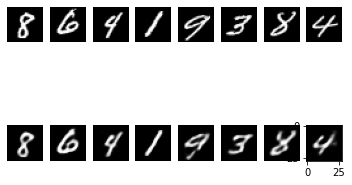

In [77]:
tem = val_samples[19]    # epoch 0
for i in range(0,8):
  img = tem[i].cpu()
  plt.axis('off')
  plt.subplot(2,8,i+1)
  plt.imshow(np.squeeze(img), cmap="gray")
for i in range(8,16):
  img = tem[i].cpu()
  plt.axis('off')
  plt.subplot(2,8,i+1)
  plt.imshow(np.squeeze(img), cmap="gray")